In [1]:
from matplotlib import pyplot as plt

In [2]:
from quick_setup import traj, start, end

In [3]:
from spice_segmenter.trajectory_properties import Distance,PhaseAngle
from spice_segmenter.occultation import Occultation, OccultationTypes

# define some properties of the trajectory
jup_distance = Distance("JUICE", "JUPITER", light_time_correction= "LT+S") 
io_distance = Distance("JUICE", "IO", light_time_correction="LT+S")

# define the occultation property
io_occultation = Occultation("JUICE", "JUPITER", "IO", light_time_correction="LT+S") # when io is occulted by jupiter as seen by juice


# phase angle
io_jup_phase_angle = PhaseAngle("JUICE", "IO", "SUN", light_time_correction="LT+S")

In [4]:
# each propertu is associated to an unit:
print(io_occultation.unit)
print(jup_distance.unit)
print(io_jup_phase_angle.unit)

dimensionless
kilometer
radian


In [5]:
from planetary_coverage import et, utc

In [6]:
t1 = et("2024-01-01T00:00:00")

print(io_occultation(t1))
print(jup_distance(t1))
print(io_jup_phase_angle(t1))

NONE
699171480.3512017
0.16947836272702554


In [7]:
# now we can evaluate the properties



print(f"{jup_distance} at {utc(t1)} = {jup_distance(t1)} {jup_distance.unit}")
print(f"{io_occultation} at {utc(t1)} = {io_occultation(t1)} {io_occultation.unit}")
print(f"{io_jup_phase_angle} at {utc(t1)} = {io_jup_phase_angle(t1)} {io_jup_phase_angle.unit}")

Distance of JUPITER from JUICE at 2024-01-01T00:00:00.000 = 699171480.3512017 kilometer
Occultation of IO by JUPITER, as seen by JUICE at 2024-01-01T00:00:00.000 = NONE dimensionless
Phase Angle of IO with respect to SUN as seen from JUICE at 2024-01-01T00:00:00.000 = 0.16947836272702554 radian


In [8]:
print(OccultationTypes.FULL.value)
print(OccultationTypes.PARTIAL.value)
print(OccultationTypes.ANNULAR.value)

1
2
3


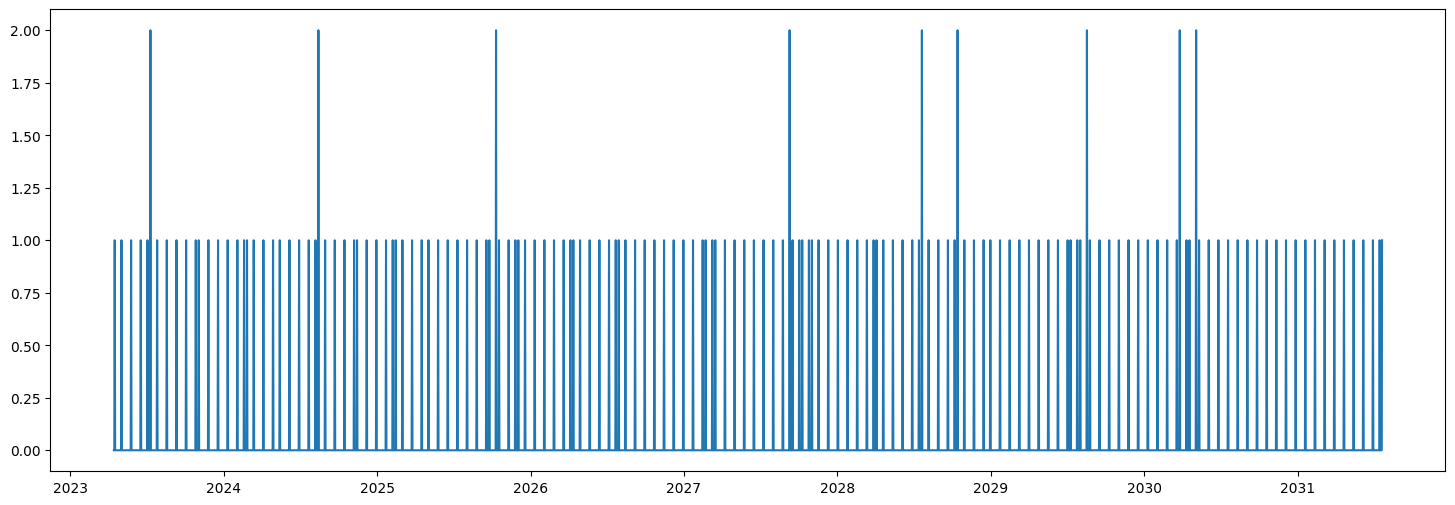

In [9]:
# properties can be evaluated over arrays (not particularly efficient, but useful for testing)
status = io_occultation(traj.ets)
plt.figure(figsize=(18,6))

plt.plot(traj.utc, [s.value for s in status])

In [10]:
# properties  can be used to create constraints:
io_occultation_constraint = (io_occultation == OccultationTypes.FULL)

print(io_occultation_constraint)

(Occultation of IO by JUPITER, as seen by JUICE == FULL)


[False False  True ... False False  True]


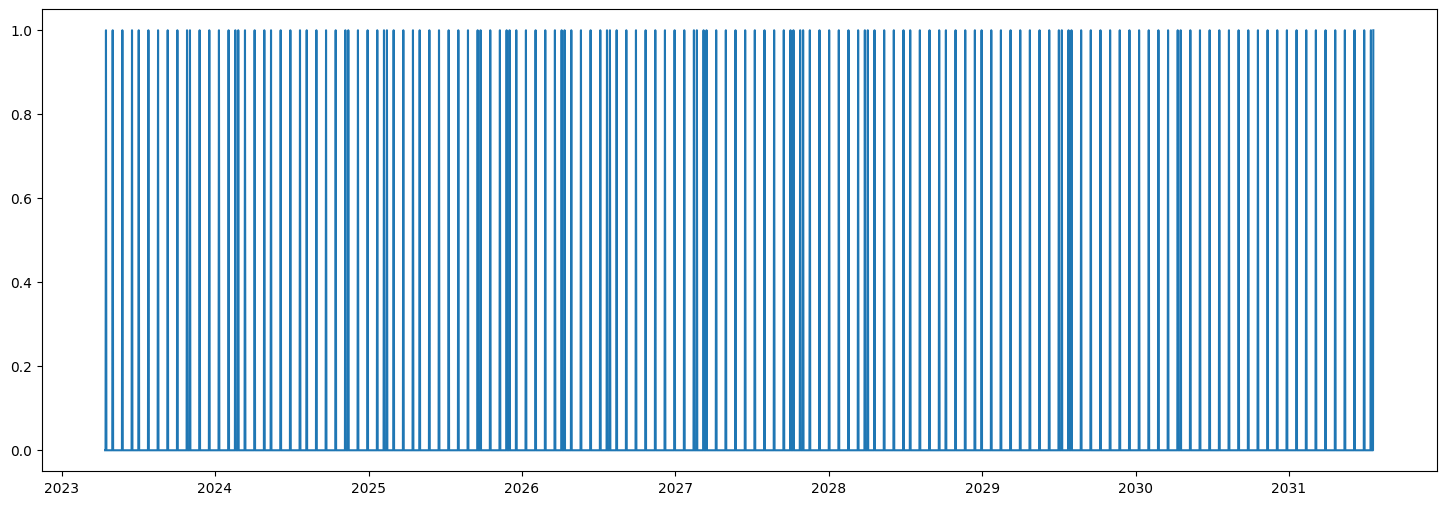

In [11]:
# also constraints can be evaluated over arrays
status = io_occultation_constraint(traj.ets)
print(status) # but they return a boolean array

plt.figure(figsize=(18,6))
plt.plot(traj.utc, status)

In [12]:
# composite constraints can be created
c = (io_jup_phase_angle > "5 deg" )  & (io_jup_phase_angle < "8 deg" ) & \
    (jup_distance < "800000000.0 km") & (io_occultation == OccultationTypes.ANY)

In [13]:
# render the tree of constraints
c.render_tree()

AND
├── AND
│   ├── AND
│   │   ├── (Phase Angle of IO with respect to SUN as seen from JUICE > 5 degree)
│   │   └── (Phase Angle of IO with respect to SUN as seen from JUICE < 8 degree)
│   └── (Distance of JUPITER from JUICE < 800000000.0 kilometer)
└── (Occultation of IO by JUPITER, as seen by JUICE == ANY)


2023-11-13 10:50:18.454 | WARNING  | spice_segmenter.trajectory_properties:__call__:472 - Comparing radian with degree. This is not recommended. Will attempt automatic conversion.
2023-11-13 10:50:18.695 | WARNING  | spice_segmenter.trajectory_properties:__call__:472 - Comparing radian with degree. This is not recommended. Will attempt automatic conversion.


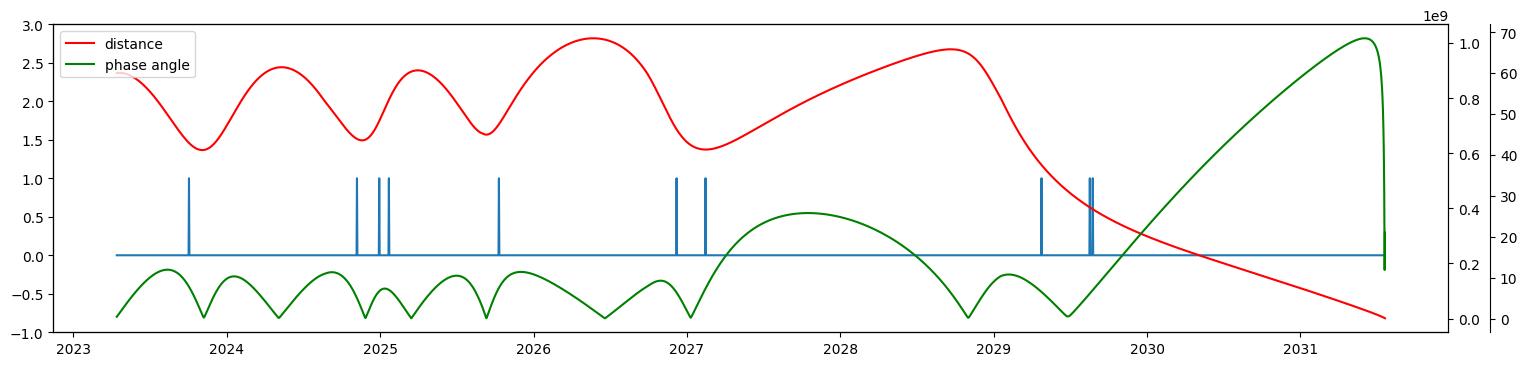

In [14]:
status = c(traj.ets) # compute the status of the constraint over the trajectory

fig, ax = plt.subplots(figsize=(18,4))
ax.plot(traj.utc, status, label='OCC status')

ax.set_ylim(-1, 3)

ax1 = plt.gca()


ax2 = ax1.twinx()

a = ax2.plot(traj.utc, traj.dist, label="distance", color="red")

ax3 = ax1.twinx()
ax3.spines.right.set_position(("axes", 1.03))

b = ax3.plot(traj.utc, traj.phase, label="phase angle", color="green")

plt.legend(a+b, [l.get_label() for l in a+b])


In [15]:
# if we want to get the exact intervals, better use a solver and find the precise start and end

from spice_segmenter.spice_window import SpiceWindow
import numpy as np

shift = np.timedelta64(1, "D")
w = SpiceWindow() # a window from start to end of the trajectory


w.add_interval(start+shift, end-shift) # add the interval from start to end of the trajectory

w

SpiceWindow(2023-04-15T12:42:17.658 to 2031-07-20T06:04:15.191, N: 1)

In [16]:
result = c.solve(w)
result

Phase angle search pass 1 of 2:   0%|          | 0/100 [00:00<?, ?%/s]

Phase angle search pass 2 of 2:   0%|          | 0/100 [00:00<?, ?%/s]

Phase angle search pass 1 of 2:   0%|          | 0/100 [00:00<?, ?%/s]

Phase angle search pass 2 of 2:   0%|          | 0/100 [00:00<?, ?%/s]

Distance pass 1 of 2:   0%|          | 0/100 [00:00<?, ?%/s]

Distance pass 2 of 2:   0%|          | 0/100 [00:00<?, ?%/s]

Occultation/transit search:   0%|          | 0/100 [00:00<?, ?%/s]

SpiceWindow(2023-10-03T11:08:19.848 to 2029-08-31T16:18:54.468, N: 118)

2023-11-13 10:50:28.519 | WARNING  | spice_segmenter.trajectory_properties:__call__:472 - Comparing radian with degree. This is not recommended. Will attempt automatic conversion.
2023-11-13 10:50:28.761 | WARNING  | spice_segmenter.trajectory_properties:__call__:472 - Comparing radian with degree. This is not recommended. Will attempt automatic conversion.


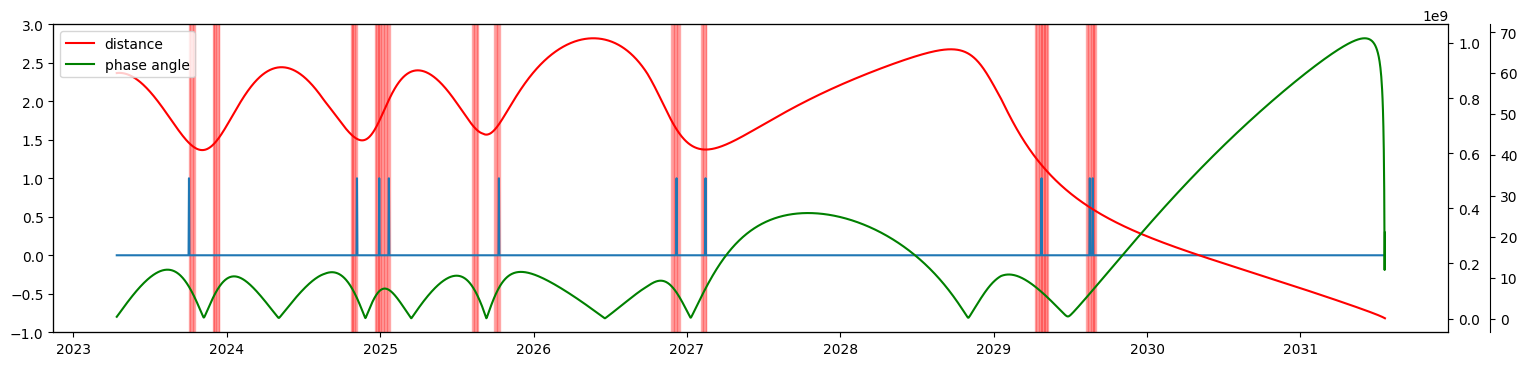

In [17]:
status = c(traj.ets)

fig, ax = plt.subplots(figsize=(18,4))

result.plot(ax=ax, color="red", label="constraint", alpha=0.3) # plot the results

ax.plot(traj.utc, status)

ax.set_ylim(-1, 3)

ax1 = plt.gca()


ax2 = ax1.twinx()

a = ax2.plot(traj.utc, traj.dist, label="distance", color="red")

ax3 = ax1.twinx()
ax3.spines.right.set_position(("axes", 1.03))

b = ax3.plot(traj.utc, traj.phase, label="phase angle", color="green")

plt.legend(a+b, [l.get_label() for l in a+b])

In [18]:
result.to_datetimerange() # as datetimerange

[2023-10-03T11:08:19 - 2023-10-03T13:20:24,
 2023-10-05T05:34:39 - 2023-10-05T07:46:42,
 2023-10-07T00:00:57 - 2023-10-07T02:12:59,
 2023-10-08T18:27:07 - 2023-10-08T20:39:08,
 2023-10-10T12:53:16 - 2023-10-10T15:05:16,
 2023-10-12T07:19:18 - 2023-10-12T09:31:18,
 2023-10-14T01:45:21 - 2023-10-14T03:57:20,
 2023-10-15T20:11:16 - 2023-10-15T22:23:15,
 2023-10-17T14:37:09 - 2023-10-17T16:49:08,
 2023-11-30T19:20:24 - 2023-11-30T21:33:17,
 2023-12-02T13:46:39 - 2023-12-02T15:59:37,
 2023-12-04T08:12:59 - 2023-12-04T10:26:00,
 2023-12-06T02:39:23 - 2023-12-06T04:52:28,
 2023-12-07T21:05:52 - 2023-12-07T23:19:01,
 2023-12-09T15:32:29 - 2023-12-09T17:45:41,
 2023-12-11T09:59:11 - 2023-12-11T12:12:27,
 2023-12-13T04:25:59 - 2023-12-13T06:39:18,
 2023-12-14T22:52:52 - 2023-12-15T01:06:15,
 2024-10-23T07:21:06 - 2024-10-23T09:36:14,
 2024-10-25T01:47:31 - 2024-10-25T04:02:38,
 2024-10-26T20:13:48 - 2024-10-26T22:28:53,
 2024-10-28T14:40:04 - 2024-10-28T16:55:09,
 2024-10-30T09:06:10 - 2024-10-3

In [19]:
result.to_pandas() # as pandas dataframe

,start,end
0,2023-10-03 11:08:20,2023-10-03 13:20:24
1,2023-10-05 05:34:39,2023-10-05 07:46:42
2,2023-10-07 00:00:58,2023-10-07 02:12:59
3,2023-10-08 18:27:08,2023-10-08 20:39:09
4,2023-10-10 12:53:16,2023-10-10 15:05:16
...,...,...
113,2029-08-24 12:19:42,2029-08-24 14:31:11
114,2029-08-26 06:46:43,2029-08-26 08:58:11
115,2029-08-28 01:13:36,2029-08-28 03:25:03
116,2029-08-29 19:40:35,2029-08-29 21:52:01


In [20]:
result.to_juice_core_csv("result.csv") # as juice core csv